In [11]:
import os
os.environ['CONFIG'] = 'scs'
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorly as tl
tl.set_backend('numpy')
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from tfm.models.pca import RPPCA, RPPCA_One_Window
from tfm.models.tensor import Tensor_One_Window_One_K
# from tfm.parafac_jax_james import initialize_factors_svd
# from tfm.tl_parafac_fix_intercept import parafac_fix_intercept
from tfm.utils import *

### load data

In [12]:
# Read tensor data
X = jnp.array(jnp.load(f'{dir_input}//mat_ptf_re_lag_{max_lag}.npz')['mat_ptf_re_rank'])
# # Read the dictionary parameters
# params = jnp.load(f'{dir_input}/dict_param_lag_{max_lag}.pkl', allow_pickle=True)

# assert params['max_lag'] == max_lag
# bin_labels, _, _, max_lag, frac_longshort, all_dates, start_date_maxlag = params.values()
# T = len(all_dates)
# start_date = all_dates[0]
# dates_fit = all_dates[all_dates < start_date_oos]
# dates_oos = all_dates[all_dates >= start_date_oos]
# T_fit = len(dates_fit)
# T_oos = len(dates_oos)

# Read FF market factor
# df_ff = jnp.load(f'{dir_input}/df_FF_factors.pkl', allow_pickle=True) * 0.01 
# df_ff = df_ff.loc[all_dates]

# # Get excess returns ie. excess to normal factor
# if input_type == 'rx':
#     X = X - X[:, 0, :][:, jnp.newaxis, :]
# if normalize_ret:
#     X = X / X.std(axis=0, keepdims=True) * df_ff['Mkt-RF'].std()

num_ptf = X.shape[2]
assert not jnp.isnan(X).any()
# X_log = jnp.log(1 + X)
T_oos = 248
T_fit = X.shape[0] - T_oos

NameError: name 'dir_input' is not defined

In [7]:
print(f'Shape of X: {X.shape}, (Months, Lag, Factor)')
X_fit, X_oos = X[:T_fit], X[T_fit:]
print(f'T_fit: {T_fit}; T_oos: {T_oos}')

# Output directory
dir_out = f'../results_oos/{os.environ['CONFIG']}/fig_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'
dir_out_table = f'../results_oos/{os.environ['CONFIG']}/tbl_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'

if not os.path.exists(dir_out):
    os.makedirs(dir_out)
if not os.path.exists(dir_out_table):
    os.makedirs(dir_out_table)

Shape of X: (535, 60, 44), (Months, Lag, Factor)
T_fit: 287; T_oos: 248


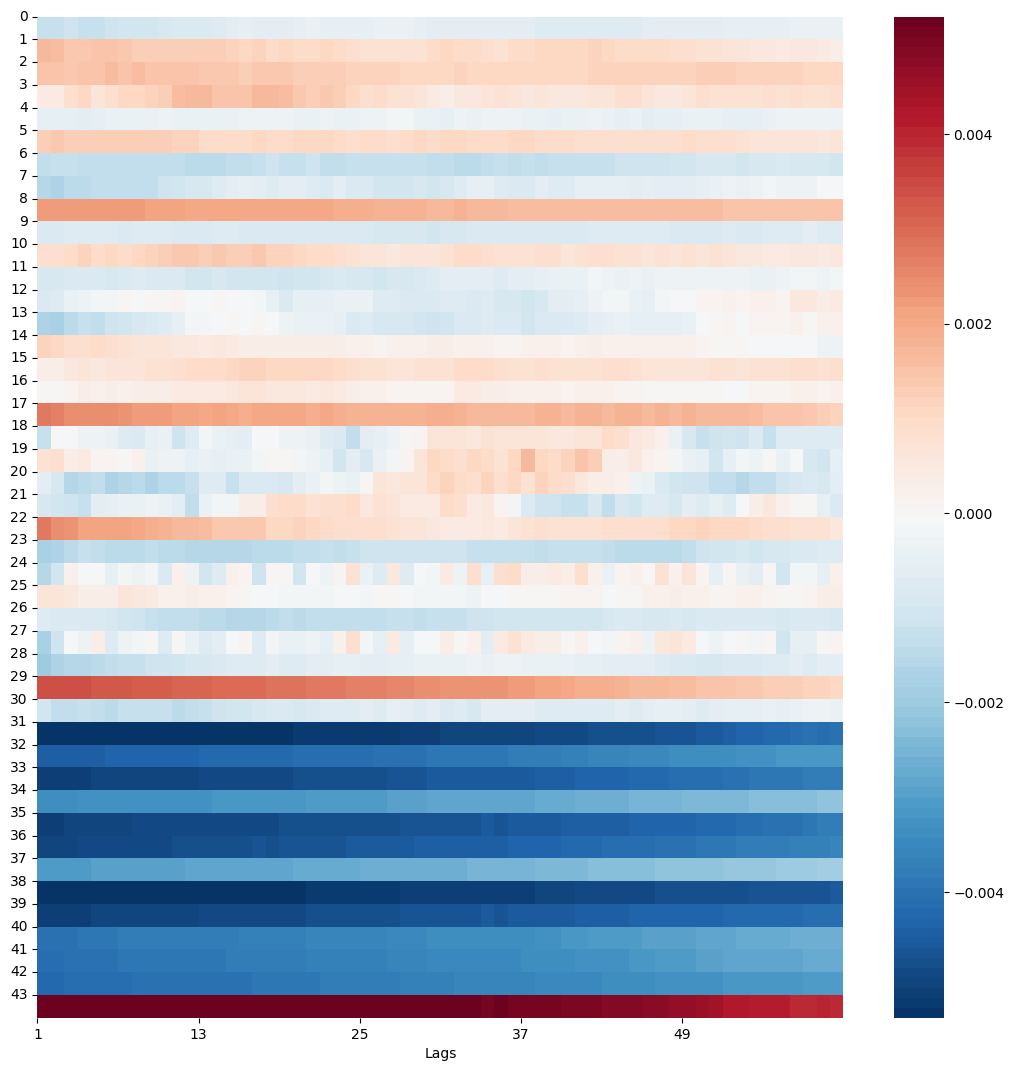

In [30]:
### plot mean return and fitted mean return
bin_labels = np.arange(X_fit.shape[2])
X_mean = X[T_fit:].mean(axis=0)
q_ylim = 0.01
ylim_mean = [np.quantile(X_mean, q_ylim), np.quantile(X_mean, 1 - q_ylim)]
# mean oos return
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(1,1,1)    
sns.heatmap(
    X_mean.T, annot=False, fmt='.0e', ax=ax, cmap=sns.color_palette("RdBu_r", n_colors=100),
    vmin=ylim_mean[0], vmax=ylim_mean[1]
);
ax.set_yticks(np.arange(len(bin_labels)))
ax.set_yticklabels(bin_labels, rotation=0);
ax.set_xticks(np.arange(0, max_lag, 12))
ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
ax.set_xlabel('Lags');
filename='term_structure_mean_ret.pdf'
fig.savefig(dir_out+filename, bbox_inches='tight')

In [31]:
# OOS settings
lst_K = [3, 5, 10, 20, 30, 40]

In [14]:
##############
## PCA
##############
dict_fit_oos = defaultdict(dict)

X_flatten = X[:, :max_lag, :].reshape(X.shape[0], -1)
X_onelag_pca = X[:, 1, :] if fit_rx else X[:, 0, :] # False in this nb

dict_fit_pca_onelag = RPPCA_one_window(
    X_onelag_pca[:T_fit], X_onelag_pca[T_fit:], lst_K, gamma=-1
)

dict_fit_pca = RPPCA_one_window(
    X_flatten[:T_fit], X_flatten[T_fit:], lst_K, gamma=-1
)

for idx_K, K in enumerate(lst_K):
    dict_fit_oos['PCA'][K] = {
        'ret_mv_oos': dict_fit_pca['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca['mat_X_fitted_oos'][:, idx_K, :].reshape(T_oos, max_lag, num_ptf),
        'sr_oos': dict_fit_pca['sr_oos'][idx_K]
    }
    
    dict_fit_oos['PCA One Lag'][K] = {
        'ret_mv_oos': dict_fit_pca_onelag['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca_onelag['mat_X_fitted_oos'][:, idx_K, :],
        'sr_oos':dict_fit_pca_onelag['sr_oos'][idx_K]
    }

100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


### tensor

In [6]:
temp = Tensor_One_Window(np.asarray(X[:T_fit]), np.asarray(X[T_fit:]), lst_K)

  0%|          | 0/7 [00:00<?, ?it/s]

Tensor: Processing K=1 ...


 14%|█▍        | 1/7 [00:00<00:04,  1.23it/s]

Oriignal [[-8.15585859e-02]
 [ 1.36273982e-02]
 [ 2.71869529e-02]
 [ 4.35013110e-04]
 [ 5.51836277e-02]
 [-9.87234584e-02]
 [-1.24973771e-02]
 [ 5.72064184e-02]
 [-1.22919170e-02]
 [-9.07471381e-02]
 [-1.18733378e-01]
 [-7.37815319e-02]
 [ 2.01252217e-02]
 [-8.08400156e-02]
 [-9.49349371e-02]
 [ 2.11384923e-02]
 [ 2.56482510e-01]
 [-6.11167589e-02]
 [-8.50544246e-04]
 [-1.14256917e-01]
 [ 5.58306291e-02]
 [-1.02831250e-01]
 [-1.20272193e-02]
 [ 3.72470652e-02]
 [-6.37398525e-02]
 [-1.93576061e-02]
 [-1.04124685e-01]
 [ 1.86816161e-02]
 [ 1.42053607e-01]
 [-8.32812952e-02]
 [-6.60311359e-02]
 [-1.09706285e-01]
 [ 5.70464669e-02]
 [ 2.11078091e-01]
 [-4.83843891e-02]
 [-9.10973349e-02]
 [-4.43275440e-02]
 [-1.47542321e-01]
 [-6.19488871e-02]
 [-4.18056356e-02]
 [-1.54984154e-02]
 [-6.96114850e-02]
 [ 6.36647622e-02]
 [ 1.77040494e-02]
 [-1.01207865e-02]
 [-1.05100209e-01]
 [-1.63386920e-02]
 [-1.91095196e-02]
 [ 2.77745035e-02]
 [ 4.50076563e-02]
 [ 1.11827992e-01]
 [ 1.07260335e-01]
 [-

 29%|██▊       | 2/7 [00:03<00:09,  1.98s/it]

Oriignal [[-4.84734060e-02  1.75607934e-02 -5.02885454e-03]
 [ 1.07194335e-02 -6.14115130e-03 -2.90576814e-02]
 [ 1.24721725e-03 -2.65018978e-02  1.63496281e-02]
 [-2.79036442e-03 -5.62928577e-03 -2.02760246e-03]
 [ 4.15630873e-02 -3.39788328e-03 -1.96450233e-02]
 [-5.27237100e-02  1.96451681e-02 -5.00584275e-02]
 [-1.62073348e-02 -1.19424583e-02 -1.56307046e-03]
 [ 5.06440667e-02 -8.37357912e-03 -8.77565808e-02]
 [ 8.99191098e-03  7.10002117e-03 -8.75901891e-02]
 [-5.12219132e-02  8.47193855e-03 -6.58756564e-02]
 [-8.78617027e-02  2.52279986e-03  1.39164790e-02]
 [-4.78796941e-02 -4.83258318e-03 -5.88794886e-02]
 [ 1.51626349e-02  7.99822380e-05 -2.21337525e-03]
 [-5.77111807e-02  7.20255879e-03  1.72990836e-02]
 [-4.43577169e-02  1.54295215e-02 -1.01819907e-01]
 [ 2.20457385e-02  3.38379294e-03 -2.86186691e-02]
 [ 1.51562976e-01 -2.93775673e-02  1.20419721e-01]
 [-4.50106669e-02 -8.67715130e-03 -3.26901570e-02]
 [-1.56181776e-02 -1.46489768e-02  3.86103575e-02]
 [-3.97474225e-02  4.4

 43%|████▎     | 3/7 [00:07<00:10,  2.63s/it]

Oriignal [[-5.19139078e-02  1.61362474e-02  9.47963356e-05 -9.70954496e-03
  -1.72610709e-02]
 [ 1.90670491e-02 -9.61879975e-03 -3.43647307e-02  1.58896026e-02
   4.20263922e-02]
 [ 8.19876933e-03 -2.24524670e-02  1.01932775e-02 -7.27127418e-03
   2.68070955e-02]
 ...
 [ 1.44578052e-01  1.75460950e-01 -6.36479085e-02 -8.41313342e-02
  -9.97104997e-02]
 [ 7.64789741e-02  6.70624640e-02 -3.87218334e-02  1.42551056e-02
  -3.77303718e-02]
 [-1.35530822e-01 -1.29033945e-01  1.99757301e-02  4.38347167e-02
   5.47529020e-02]]
Tensor: Processing K=10 ...


 57%|█████▋    | 4/7 [00:13<00:12,  4.15s/it]

Oriignal [[ 0.02249865 -0.0617842   0.0159648  ...  0.02399044 -0.03197333
  -0.01568634]
 [ 0.00165044  0.01970499 -0.00211536 ...  0.05484263  0.04428509
  -0.04539203]
 [-0.0152979   0.02973279 -0.01887504 ... -0.00898355  0.02812243
  -0.02514183]
 ...
 [-0.02147349  0.00567392  0.14723311 ...  0.02796381 -0.1377966
  -0.06496154]
 [ 0.00967896  0.01170752  0.06346484 ...  0.03853983 -0.01326819
   0.02200713]
 [ 0.01423688 -0.04667126 -0.11539863 ...  0.01936094  0.08025886
   0.00907365]]
Tensor: Processing K=20 ...
Oriignal [[ 0.01894022 -0.09221889  0.02002219 ... -0.04734721  0.04575242
   0.01299361]
 [-0.01516143  0.02071994 -0.02772125 ... -0.02594901  0.03311601
   0.01708221]
 [ 0.0131997   0.03839236 -0.00256293 ... -0.04464977  0.00642976
  -0.02934219]
 ...
 [-0.24326742  0.03481836 -0.05435859 ... -0.05245971  0.12964517
  -0.02678617]
 [-0.07476349  0.01919889  0.02509452 ...  0.01922807  0.02384222
  -0.01963655]
 [ 0.11373958 -0.04836311 -0.05727769 ... -0.10787396

 71%|███████▏  | 5/7 [00:24<00:13,  6.74s/it]

Tensor: Processing K=30 ...
Oriignal [[-0.1123956   0.00571021  0.01860316 ... -0.0475701   0.04921691
  -0.02800793]
 [ 0.00242023  0.01349025 -0.00852623 ... -0.04264163  0.03970789
  -0.03477875]
 [ 0.03098448 -0.0391567  -0.02749542 ... -0.03127374  0.01368747
   0.00341064]
 ...
 [ 0.04873168  0.12627032  0.15202763 ...  0.12071092 -0.12227727
  -0.07368877]
 [ 0.02309942  0.09746846  0.04720586 ...  0.03499118 -0.01591036
  -0.02768485]
 [-0.074483   -0.06738329 -0.07696676 ... -0.15221191  0.08627131
   0.02446221]]


 86%|████████▌ | 6/7 [00:41<00:10, 10.19s/it]

Tensor: Processing K=40 ...
Oriignal [[ 0.0009974  -0.07484317 -0.00386526 ... -0.01323665 -0.06806137
  -0.01282169]
 [ 0.01407959  0.01106225 -0.00298068 ...  0.00273003 -0.01283998
  -0.01626007]
 [ 0.00381141  0.02715108  0.02364466 ... -0.00226363  0.01758404
   0.00238301]
 ...
 [ 0.18856894  0.10366265 -0.06553841 ...  0.14729182 -0.0507471
  -0.03240959]
 [ 0.04487805  0.07879849  0.02546039 ... -0.01255218 -0.07062798
  -0.01989091]
 [-0.03435552 -0.156824   -0.00276357 ... -0.01186093  0.19925779
   0.05526802]]


100%|██████████| 7/7 [01:04<00:00,  9.25s/it]


In [7]:
res = {}
for K in lst_K:
    weights, factors = initialize_factors_svd(X[:T_fit], K, random_state=random_seed)
    res[K] = Tensor_One_Window_One_K(X[:T_fit], X[T_fit:], weights, factors, K, random_seed=random_seed)
    

In [41]:
for K in lst_K:
    A = res[K]['X_fitted_oos']
    B = temp[K]['X_fitted_oos']
    # Compute relative error: |A - B| / |B| where |B| != 0
    mask = (B != 0)  # Avoid division by zero
    relative_error = jnp.abs(A - B) / jnp.abs(B + 1e-10)  # Add small epsilon to avoid division by zero
    
    # Compute mean relative error
    mean_relative_error = jnp.mean(relative_error)
    print(f"K={K}: Average relative error = {mean_relative_error:.2e}")
    
    # Optional: Also show max relative error
    max_relative_error = jnp.max(relative_error)
    print(f"K={K}: Maximum relative error = {max_relative_error:.2e}")

K=1: Average relative error = 8.55e-04
K=1: Maximum relative error = 1.77e-02
K=3: Average relative error = 1.26e-07
K=3: Maximum relative error = 6.63e-03
K=5: Average relative error = 6.36e-07
K=5: Maximum relative error = 3.99e-02
K=10: Average relative error = 2.15e-06
K=10: Maximum relative error = 1.23e-01
K=20: Average relative error = 1.32e-05
K=20: Maximum relative error = 1.49e+00
K=30: Average relative error = 9.81e-05
K=30: Maximum relative error = 1.80e+00
K=40: Average relative error = 2.89e-04
K=40: Maximum relative error = 3.97e+01


In [54]:
for K in lst_K:
    jax = res[K]['sr_oos']
    orig = temp[K]['sr_oos']
    relative_error = abs(jax - orig) / abs(orig)
    if K == 1:
        jax, orig, relative_error = jax[0], orig[0], relative_error[0]
    print(f"K={K}: Sharpe relative error={relative_error:.4e}, jax={jax:.8f}, orig={orig:.8f}")

K=1: Sharpe relative error=8.9010e-06, jax=0.19367997, orig=0.19368170
K=3: Sharpe relative error=1.4197e-10, jax=0.22954691, orig=0.22954691
K=5: Sharpe relative error=2.4873e-08, jax=0.26747827, orig=0.26747826
K=10: Sharpe relative error=5.9542e-08, jax=0.08692981, orig=0.08692981
K=20: Sharpe relative error=1.1774e-08, jax=0.30118209, orig=0.30118208
K=30: Sharpe relative error=3.0740e-06, jax=0.21080771, orig=0.21080707
K=40: Sharpe relative error=1.3509e-05, jax=0.19162028, orig=0.19162287


In [8]:
# mean fitted oos return
for method in ['Tensor', 'PCA']:
    for idx_K, K in enumerate(lst_K):
        # get fitted expected return
        X_fit_oos=dict_fit_oos[method][K]['X_fitted_oos']
        expected_re_fit=X_fit_oos.mean(axis=0)

        # plot
        fig=plt.figure(figsize=(13,13))
        ax=fig.add_subplot(1,1,1)    
        sns.heatmap(expected_re_fit.T,
                    annot=False,
                    fmt='.0e',
                    ax=ax,
                    cmap=sns.color_palette("RdBu_r", n_colors=100),
                    vmin=ylim_mean[0], vmax=ylim_mean[1]
        );
        ax.set_yticks(np.arange(len(bin_labels)))
        ax.set_yticklabels(bin_labels, rotation=0);
        ax.set_xticks(np.arange(0,max_lag,12))
        ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
        ax.set_xlabel('Lags');

        filename='term_structure_{}_fitted_ret_K{}.pdf'\
            .format(method, K)
        #print(filename)
        fig.savefig(dir_out+filename, bbox_inches='tight')
        plt.close('all')



In [9]:
def calc_eval_metrics(X_in, X_rc):

    X_rc_1ex = X_rc[:,0,:]

    eps = X_in - X_rc # dim: (T, max_lag, num_ptf)
    eps_1ex = (X_in - X_in[:, 0, :][:,np.newaxis,:]) - (X_rc - X_rc_1ex[:,np.newaxis,:])

    ### metrics, not aggregated
    # pricing error
    alpha = eps.mean(axis=0) # dim: (max_lag, num_ptf)
    alpha_1ex = eps_1ex.mean(axis=0) # dim: (max_lag, num_ptf)

    # unexplained variance
    var_resid = (eps**2).mean(axis=0) - alpha**2 # dim: (max_lag, num_ptf)
    var_resid_1ex = (eps_1ex**2).mean(axis=0) - alpha_1ex**2 # dim: (max_lag, num_ptf)
    

    ### normalized averaged metrics
    # XS-alpha
    xs_alpha = np.sqrt((alpha**2).mean()) # scalar
    xs_alpha_1ex = np.sqrt((alpha_1ex**2).mean()) # scalar

    xs_alpha_ptf  = np.sqrt((alpha**2).mean(axis=0)) # dim: (num_ptf, )
    xs_alpha_ptf_1ex  = np.sqrt((alpha_1ex**2).mean(axis=0)) # dim: (num_ptf, )
    
    xs_alpha_lag  = np.sqrt((alpha**2).mean(axis=1)) # dim: (max_lag, )
    xs_alpha_lag_1ex  = np.sqrt((alpha_1ex**2).mean(axis=1)) # dim: (max_lag, )

    # unexplained var
    sigma_eps = np.sqrt(var_resid.mean()) \
        /np.sqrt(np.var(X_in, axis=0).mean()) # scalar
    sigma_eps_1ex = np.sqrt(var_resid_1ex.mean())\
        /np.sqrt(np.var(X_in - X_in[:,0,:][:,np.newaxis,:], axis=0).mean()) # scalar
    
    
    # fitting error decomposition into lag and cross components
    eps_cross=eps[:,0,:]
    eps_lag=eps-eps_cross[:,np.newaxis,:]

    eps_cross_rms=(eps_cross**2).mean(axis=0)**.5
    eps_lag_rms=(eps_lag**2).mean(axis=0)**.5
    
    
    # fitting rmse averaged over two dimensions
    dict_rmse={}
    lst_mean_axis=[(1,2),(0,2),(0,1)]
    lst_rmse_dim_name=['rmse_time', 'rmse_lag', 'rmse_portfolio']

    for mean_axis, dim_name in zip(lst_mean_axis,lst_rmse_dim_name):
        rmse_dim=np.sqrt(((X_in-X_rc)**2).mean(axis=mean_axis))
        dict_rmse[dim_name]=rmse_dim
    
    ### record results
    dict_eval = {
                 'alpha':alpha,
                'alpha_1ex':alpha_1ex,
                'var_resid':var_resid,
                'var_resid_1ex':var_resid_1ex,
                 
                'xs_alpha':xs_alpha,
                'xs_alpha_1ex':xs_alpha_1ex,
                'xs_alpha_ptf':xs_alpha_ptf,
                'xs_alpha_ptf_1ex':xs_alpha_ptf_1ex,
                 'xs_alpha_lag':xs_alpha_lag,
                 'xs_alpha_lag_1ex':xs_alpha_lag_1ex,
                 
                'sigma_eps':sigma_eps,
                'sigma_eps_1ex':sigma_eps_1ex,
                 'eps_cross_rms':eps_cross_rms,
                 'eps_lag_rms':eps_lag_rms
                }
    dict_eval.update(dict_rmse)
    
    return dict_eval

In [10]:
def print_matrix(A,row_title=None,col_title=None,print_multiplier=1, fmt='{:.3f}'):
    '''
    print(print_matrix(A))
    '''
    str_out=''
    (num_row,num_col)=A.shape
    
    if row_title is not None:
        assert len(row_title)==num_row
        
    if col_title is not None:
        for i,title in enumerate(col_title):
            if i==len(col_title)-1:
                str_out+=title+'\\\\'
            else:
                str_out+=title+'&'
        str_out+='\n'
        
    for i in range(0,num_row):
        str_temp=''
        if row_title is not None:
            str_temp+=row_title[i]+'&'
        for j in range(0,num_col):
            str_temp+=fmt.format(A[i,j]*print_multiplier)
            if j==num_col-1:
                str_temp+='\\\\'
            else:
                str_temp+='&'
        #str_temp=str_temp.replace('<','$<$').replace('>','$>$')
        str_out+=str_temp+'\n'
    return str_out

def get_plot_ylim(dict_eval_method, lst_K, key, q_lb=0.1):
    q_ub=1-q_lb
    
    ylim = [float('inf'), -float('inf')]
    for K in lst_K:
        ylim[0] = min(ylim[0], np.quantile(dict_eval_method[K]['eval'][key], q_lb))
        ylim[1] = max(ylim[1], np.quantile(dict_eval_method[K]['eval'][key], q_ub))
        
    return ylim
    
def collect_eval_metric(dict_eval_method, lst_K, key):
    temp = []
    for K in lst_K:
        temp.append(np.array(dict_eval_method[K]['eval'][key]))
    return np.stack(temp, axis=-1)

In [11]:
for method in ['Tensor', 'PCA']: 
    for idx_K, K in enumerate(lst_K):

        X_rc=dict_fit_oos[method][K]['X_fitted_oos']

        dict_eval_temp=calc_eval_metrics(X[T_fit:], X_rc)
        dict_fit_oos[method][K]['eval']=dict_eval_temp

In [21]:
### alpha
print_multiplier=1

for method in ['Tensor','PCA']:
    for K in lst_K:
        dict_eval=dict_fit_oos[method][K]['eval']
        latex=print_matrix(dict_eval['alpha'], fmt='{:.2e}', 
                        col_title=[str(s) for s in bin_labels],
                        row_title=['Lag {}'.format(i+1) for i in range(max_lag)],
                         print_multiplier=print_multiplier)
        
        text_file = open(dir_out_table+'tbl_{}_alpha_K_{}.txt'.format(method, K), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; K: {}\n\n'.format(print_multiplier, method, K))
        text_file.write(latex)
        text_file.close()

In [22]:
### table for xs-alpha, averaged over lag or ptf dim

print_multiplier=1e3

for method in ['Tensor', 'PCA']:
    for postfix in ['','_1ex']:
        dict_eval=dict_fit_oos[method]
        
        latex_ptf=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_ptf'+postfix),
                     row_title=[str(s) for s in bin_labels],
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')


        latex_lag=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_lag'+postfix),
                     row_title=[str(L) for L in range(1,1+max_lag)],
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')

        # save rms alpha as table in txt for latex
        text_file = open(dir_out_table+'tbl_{}_xs_alpha_ptf{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_ptf)
        text_file.close()

        text_file = open(dir_out_table+'tbl_{}_xs_alpha_lag{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_lag)
        text_file.close()

In [23]:
### sigma_eps unexplained variance
print_multiplier = 1

for postfix in ['','_1ex']:
    

    metric_tensor = collect_eval_metric(dict_fit_oos['Tensor'],
                                        lst_K, 'sigma_eps'+postfix)
    metric_pca = collect_eval_metric(dict_fit_oos['Tensor'],
                                     lst_K, 'sigma_eps'+postfix)
    metric_pca = np.real(metric_pca)
    metric = np.stack((metric_tensor,metric_pca), axis=-1)

    latex = print_matrix(metric,
                 col_title=['Tensor', 'PCA'],
                 row_title=[str(K) for K in lst_K],
                 print_multiplier=print_multiplier,
                 fmt='{:.2f}')

    text_file = open(dir_out_table+'tbl_{}_sigma_eps{}.txt'.format(method, postfix), 'w')
    text_file.write('Multiplier: {:.2e}\n\n'.format(print_multiplier))
    text_file.write(latex)
    text_file.close()

In [25]:
### table for eps_cross_rms
print_multiplier=1e2

for method in ['Tensor','PCA']:
    latex=print_matrix(collect_eval_metric(dict_fit_oos[method],
                                           lst_K, 'eps_cross_rms'),
                                         fmt='{:.2f}', 
                                        col_title=[str(K) for K in lst_K],
                                         row_title=[str(s) for s in bin_labels],
                                         print_multiplier=print_multiplier)
    
    text_file = open(dir_out_table+'tbl_{}_rms_eps_cross.txt'.format(method), 'w')
    text_file.write('Multiplier: {:.2e}; Method: {} \n\n'.format(print_multiplier, method))
    text_file.write(latex)
    text_file.close()

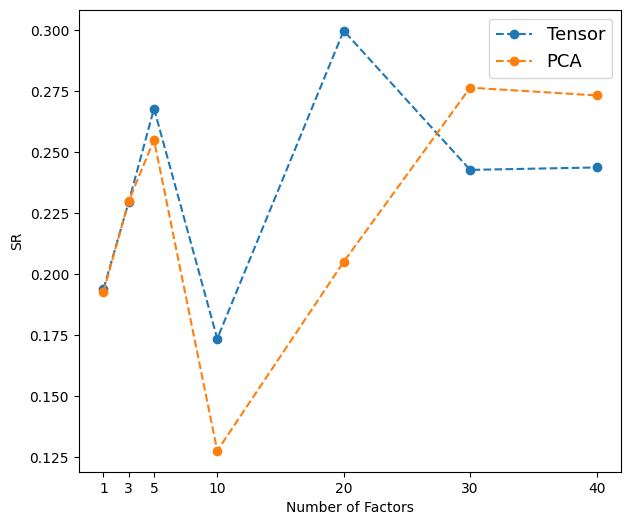

In [26]:
#ylim=[-0.1, 1.9]
filename = 'sr.pdf'

dict_fit_oos['Tensor'][1]['sr_oos'] = dict_fit_oos['Tensor'][1]['sr_oos'][0]

fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)

for method in ['Tensor','PCA']:
    ax.plot(lst_K, np.array([dict_fit_oos[method][K]['sr_oos'] for K in lst_K]),
            '--o',label=method)
ax.legend(fontsize=13);
ax.set_ylabel('SR')
ax.set_xlabel('Number of Factors')
ax.set_xticks(lst_K);
#ax.set_ylim(ylim)

fig.savefig(dir_out, bbox_inches='tight')

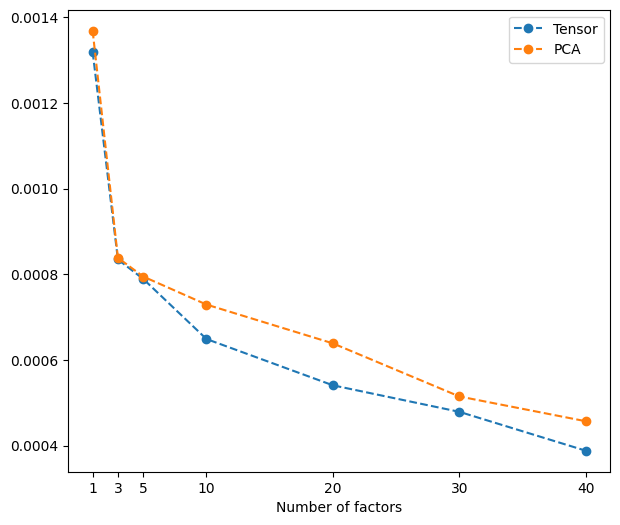

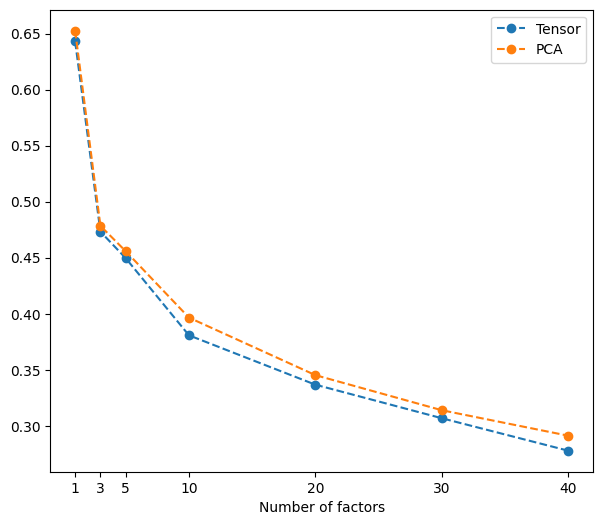

In [27]:
### xs-alpha and sigma_eps

for key in ['xs_alpha','sigma_eps']:

    fig=plt.figure(figsize=(7,6))
    ax=fig.add_subplot(1,1,1)
    for method in ['Tensor','PCA']:
        metric=np.real(collect_eval_metric(dict_fit_oos[method], lst_K, key))
        ax.plot(lst_K, metric,'--o',
                label=method)
    ax.set_xlabel('Number of factors');
    ax.legend();
    ax.set_xticks(lst_K);
    fig.savefig(dir_out+'{}.pdf'.format(key), bbox_inches='tight')

In [28]:
### plot term structure of alpha
lst_key = ['alpha','var_resid', 'eps_lag_rms']
filename = 'term_structure_{}_{}_K{}.pdf'
method='Tensor'


for method in ['Tensor', 'PCA']: 
    for key in lst_key:
        ylim = get_plot_ylim(dict_fit_oos[method], lst_K, key, q_lb=0.1)

        for K in lst_K:
            fig=plt.figure(figsize=(13,13))
            ax=fig.add_subplot(1,1,1)    
            sns.heatmap(dict_fit_oos[method][K]['eval'][key].T,
                        annot=False,
                        fmt='.0e',
                        ax=ax,
                        cmap=sns.color_palette("RdBu_r", n_colors=100),
                       vmin=ylim[0], vmax=ylim[1]);

            ax.set_yticks(np.arange(len(bin_labels)))
            ax.set_yticklabels(bin_labels ,rotation=0);

            ax.set_xticks(np.arange(0,max_lag,12))
            ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
            ax.set_xlabel('Lags');

            fig.savefig(dir_out+filename.format(method, key, K), bbox_inches='tight')
            plt.close('all')

